In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from ffflows.models import BaseFlow
from ffflows.utils import set_trainable
from ffflows.utils import get_activation, spline_inn, get_flow4flow, get_conditional_data

from nflows.distributions import StandardNormal

from ffflows.data.conditional_plane import ScienceDataset

import yaml


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [2]:
# Get training data

train_sim_data = torch.from_numpy(np.load("LHCO_data/train_sim_data.npy")).to(torch.float32)
val_sim_data = torch.from_numpy(np.load("LHCO_data/val_sim_data.npy")).to(torch.float32)
train_dat_data = torch.from_numpy(np.load("LHCO_data/train_dat_data.npy")).to(torch.float32)
val_dat_data = torch.from_numpy(np.load("LHCO_data/val_dat_data.npy")).to(torch.float32)

train_sim_cont = torch.from_numpy(np.load("LHCO_data/train_sim_cont.npy").reshape(-1, 1)).to(torch.float32)
val_sim_cont = torch.from_numpy(np.load("LHCO_data/val_sim_cont.npy").reshape(-1, 1)).to(torch.float32)
train_dat_cont = torch.from_numpy(np.load("LHCO_data/train_dat_cont.npy").reshape(-1, 1)).to(torch.float32)
val_dat_cont = torch.from_numpy(np.load("LHCO_data/val_dat_cont.npy").reshape(-1, 1)).to(torch.float32)

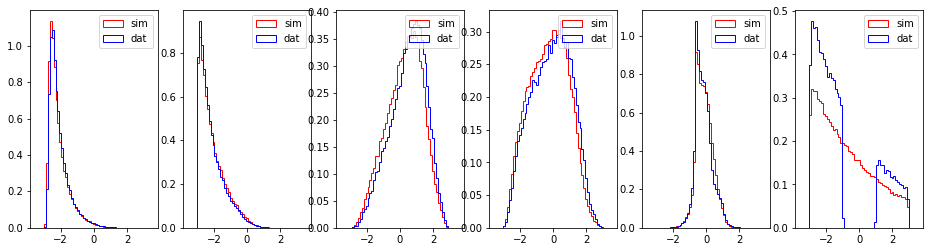

In [3]:
# Plot training data

bins = np.linspace(-3.5, 3.5, 60)

fig, ax = plt.subplots(1, 6, figsize = (16, 4))

for i in range(5):
    ax[i].hist(val_sim_data[:,i].numpy(), bins = bins, label = "sim", histtype = "step", density = True, color = "red")
    ax[i].hist(val_dat_data[:,i].numpy(), bins = bins, label = "dat", histtype = "step", density = True, color = "blue")
    ax[i].legend()
    
# context
ax[5].hist(val_sim_cont.numpy(), bins = bins, label = "sim", histtype = "step", density = True, color = "red")
ax[5].hist(val_dat_cont.numpy(), bins = bins, label = "dat", histtype = "step", density = True, color = "blue")
ax[5].legend()
    
plt.show()

# Set up directories to hold the transformed data


In [4]:
transformed_data = {}
transformed_data["reference"] = val_sim_data.numpy()

# Double base flow

In [5]:
flow_dir = "/global/home/users/rrmastandrea/flows4flows/writeup2/science"

with open(f"{flow_dir}/science.yaml") as f:
    defaults_doublebase = yaml.safe_load(f)

base_flow_left_path = f"{flow_dir}/base_left/epoch_59.pt"
base_flow_right_path = f"{flow_dir}/base_right/epoch_59.pt"

In [6]:
# load in the flow

base_flow_left = BaseFlow(spline_inn(defaults_doublebase["general"]["data_dim"],
                                    nodes = defaults_doublebase["base_dist"]["left"]["nnodes"],
                                 num_blocks =   defaults_doublebase["base_dist"]["left"]["nblocks"],
                                    num_stack = defaults_doublebase["base_dist"]["left"]["nstack"],
                                    tail_bound=4.0,
                                    num_bins=defaults_doublebase["base_dist"]["left"]["nbins"],
                                    context_features=defaults_doublebase["general"]["ncond"]
                                    ),
                         StandardNormal([defaults_doublebase["general"]["data_dim"]])
                         )
    
base_flow_left.load_state_dict(torch.load(base_flow_left_path, map_location=device))


base_flow_right = BaseFlow(spline_inn(defaults_doublebase["general"]["data_dim"],
                                    nodes = defaults_doublebase["base_dist"]["right"]["nnodes"],
                                 num_blocks =   defaults_doublebase["base_dist"]["right"]["nblocks"],
                                    num_stack = defaults_doublebase["base_dist"]["right"]["nstack"],
                                    tail_bound=4.0,
                                    num_bins=defaults_doublebase["base_dist"]["right"]["nbins"],
                                    context_features=defaults_doublebase["general"]["ncond"]
                                    ),
                         StandardNormal([defaults_doublebase["general"]["data_dim"]])
                         )
    

base_flow_right.load_state_dict(torch.load(base_flow_right_path, map_location=device))
        
set_trainable(base_flow_left, False)        
set_trainable(base_flow_right, False)
            

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/torch/cuda/__init__.py:143: UserWarning: 
NVIDIA A40 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA A40 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


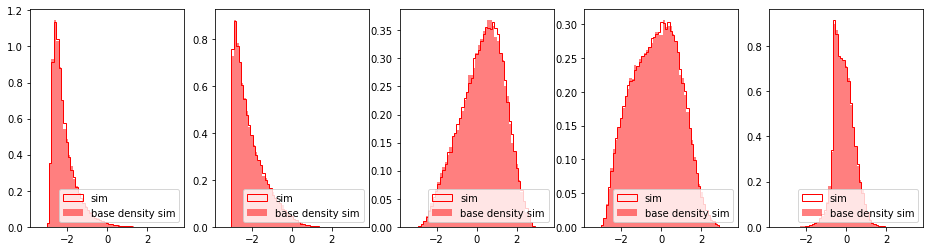

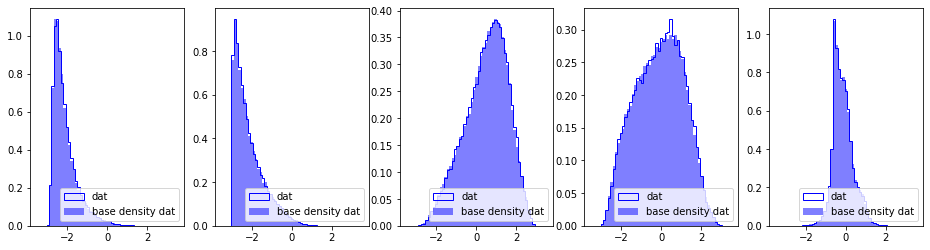

In [7]:
# check training
sim_dataset = ScienceDataset(val_sim_data, val_sim_cont)
dat_dataset = ScienceDataset(val_dat_data, val_dat_cont)

# sample from the sim_bd
n_transform = 55753

noise = torch.normal(0, 1, size=(n_transform, 5))
bd_sim_samples, _ = base_flow_left._transform.inverse(noise, sim_dataset.conditions[:n_transform])
bd_dat_samples, _ = base_flow_right._transform.inverse(noise, dat_dataset.conditions[:n_transform])


bins = np.linspace(-3.5, 3.5, 60)

fig, ax = plt.subplots(1, 5, figsize = (16, 4))
for i in range(5):
    ax[i].hist(val_sim_data[:,i].numpy(), bins = bins, label = "sim", histtype = "step", density = True, color = "red")
    ax[i].hist(bd_sim_samples[:,i].numpy(), bins = bins, label = "base density sim", histtype = "bar", density = True, color = "red", alpha = 0.5)
    ax[i].legend(loc = "lower right")
    
plt.show()


fig, ax = plt.subplots(1, 5, figsize = (16, 4))
for i in range(5):
    ax[i].hist(val_dat_data[:,i].numpy(), bins = bins, label = "dat", histtype = "step", density = True, color = "blue")
    ax[i].hist(bd_dat_samples[:,i].numpy(), bins = bins, label = "base density dat", histtype = "bar", density = True, color = "blue", alpha = 0.5)
    ax[i].legend(loc = "lower right")
    
plt.show()

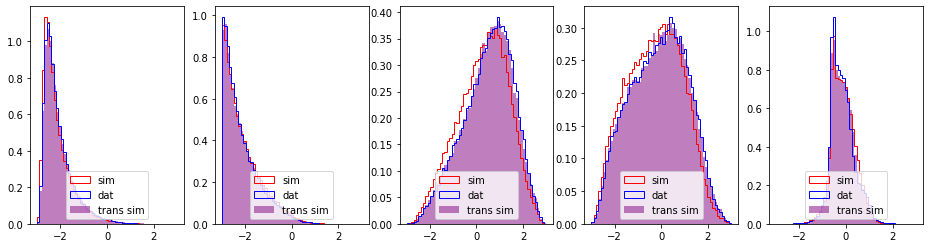

In [8]:
# transform


sim_to_noise, _ = base_flow_left._transform(sim_dataset.data[:n_transform], sim_dataset.conditions[:n_transform])
transformed_sim, _ = base_flow_right._transform.inverse(sim_to_noise, sim_dataset.conditions[:n_transform])


bins = np.linspace(-3, 3, 60)

fig, ax = plt.subplots(1, 5, figsize = (16, 4))
for i in range(5):
    ax[i].hist(val_sim_data[:,i].numpy(), bins = bins, label = "sim", histtype = "step", density = True, color = "red")
    ax[i].hist(val_dat_data[:,i].numpy(), bins = bins, label = "dat", histtype = "step", density = True, color = "blue")
    ax[i].hist(transformed_sim[:,i].numpy(), bins = bins, label = "trans sim", histtype = "bar", density = True, color = "purple", alpha = 0.5)
    ax[i].legend(loc = "lower center")
plt.show()

transformed_data["base_transfer"] = transformed_sim.numpy()


# Transfer flows

In [9]:
flow_dirs = {"f4f":"/global/home/users/rrmastandrea/flows4flows/writeup2/science",
            "inverse":"/global/home/users/rrmastandrea/flows4flows/writeup2/science_inv",
             "L1":"/global/home/users/rrmastandrea/flows4flows/writeup2/science_L1",
           #  "L1_identinit":"/global/home/users/rrmastandrea/flows4flows/writeup2/science_L1_identinit",
             "identinit":"/global/home/users/rrmastandrea/flows4flows/writeup2/science_identinit",
            }


loaded_flows = {}
for key in flow_dirs.keys():
    
    loc_flow_dir = flow_dirs[key]
    
    print(f"On key {key}...")
    
    yaml_key = loc_flow_dir.split("/")[-1]
    
    with open(f"{loc_flow_dir}/{yaml_key}.yaml") as f:
        loc_defaults = yaml.safe_load(f)

    # load in the flow
    loc_transfer_flow = get_flow4flow("discretebasecondition",
                               spline_inn(loc_defaults["general"]["data_dim"],
                                          nodes=loc_defaults["top_transformer"]["nnodes"],
                                          num_blocks=loc_defaults["top_transformer"]["nblocks"],
                                          num_stack=loc_defaults["top_transformer"]["nstack"],
                                          tail_bound=4.0,
                                          num_bins=loc_defaults["top_transformer"]["nbins"],
                                          context_features=loc_defaults["general"]["ncond"],
                                          identity_init=loc_defaults["top_transformer"]["identity_init"],
                                          flow_for_flow=True
                                          ),
                               base_flow_left)
    
    if key != "inverse":
        loc_transfer_flow_path = f"{loc_flow_dir}/f4f/epoch_63.pt"
    else:
        loc_transfer_flow_path = f"{loc_flow_dir}/f4f_inv/epoch_63.pt"
    
    loc_transfer_flow.load_state_dict(torch.load(loc_transfer_flow_path, map_location=device))
        
    set_trainable(loc_transfer_flow, False)
    
    loaded_flows[key] = loc_transfer_flow
            
 

On key f4f...
On key inverse...
On key L1...
On key identinit...


In [10]:
# transform
inverse = False


for key in flow_dirs.keys():

    loc_transformed_sim, _ = loaded_flows[key].transform(sim_dataset.data[:n_transform], sim_dataset.conditions[:n_transform], dat_dataset.conditions[:n_transform], inverse = inverse)
    transformed_data[key] = loc_transformed_sim.numpy()



/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib6

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64

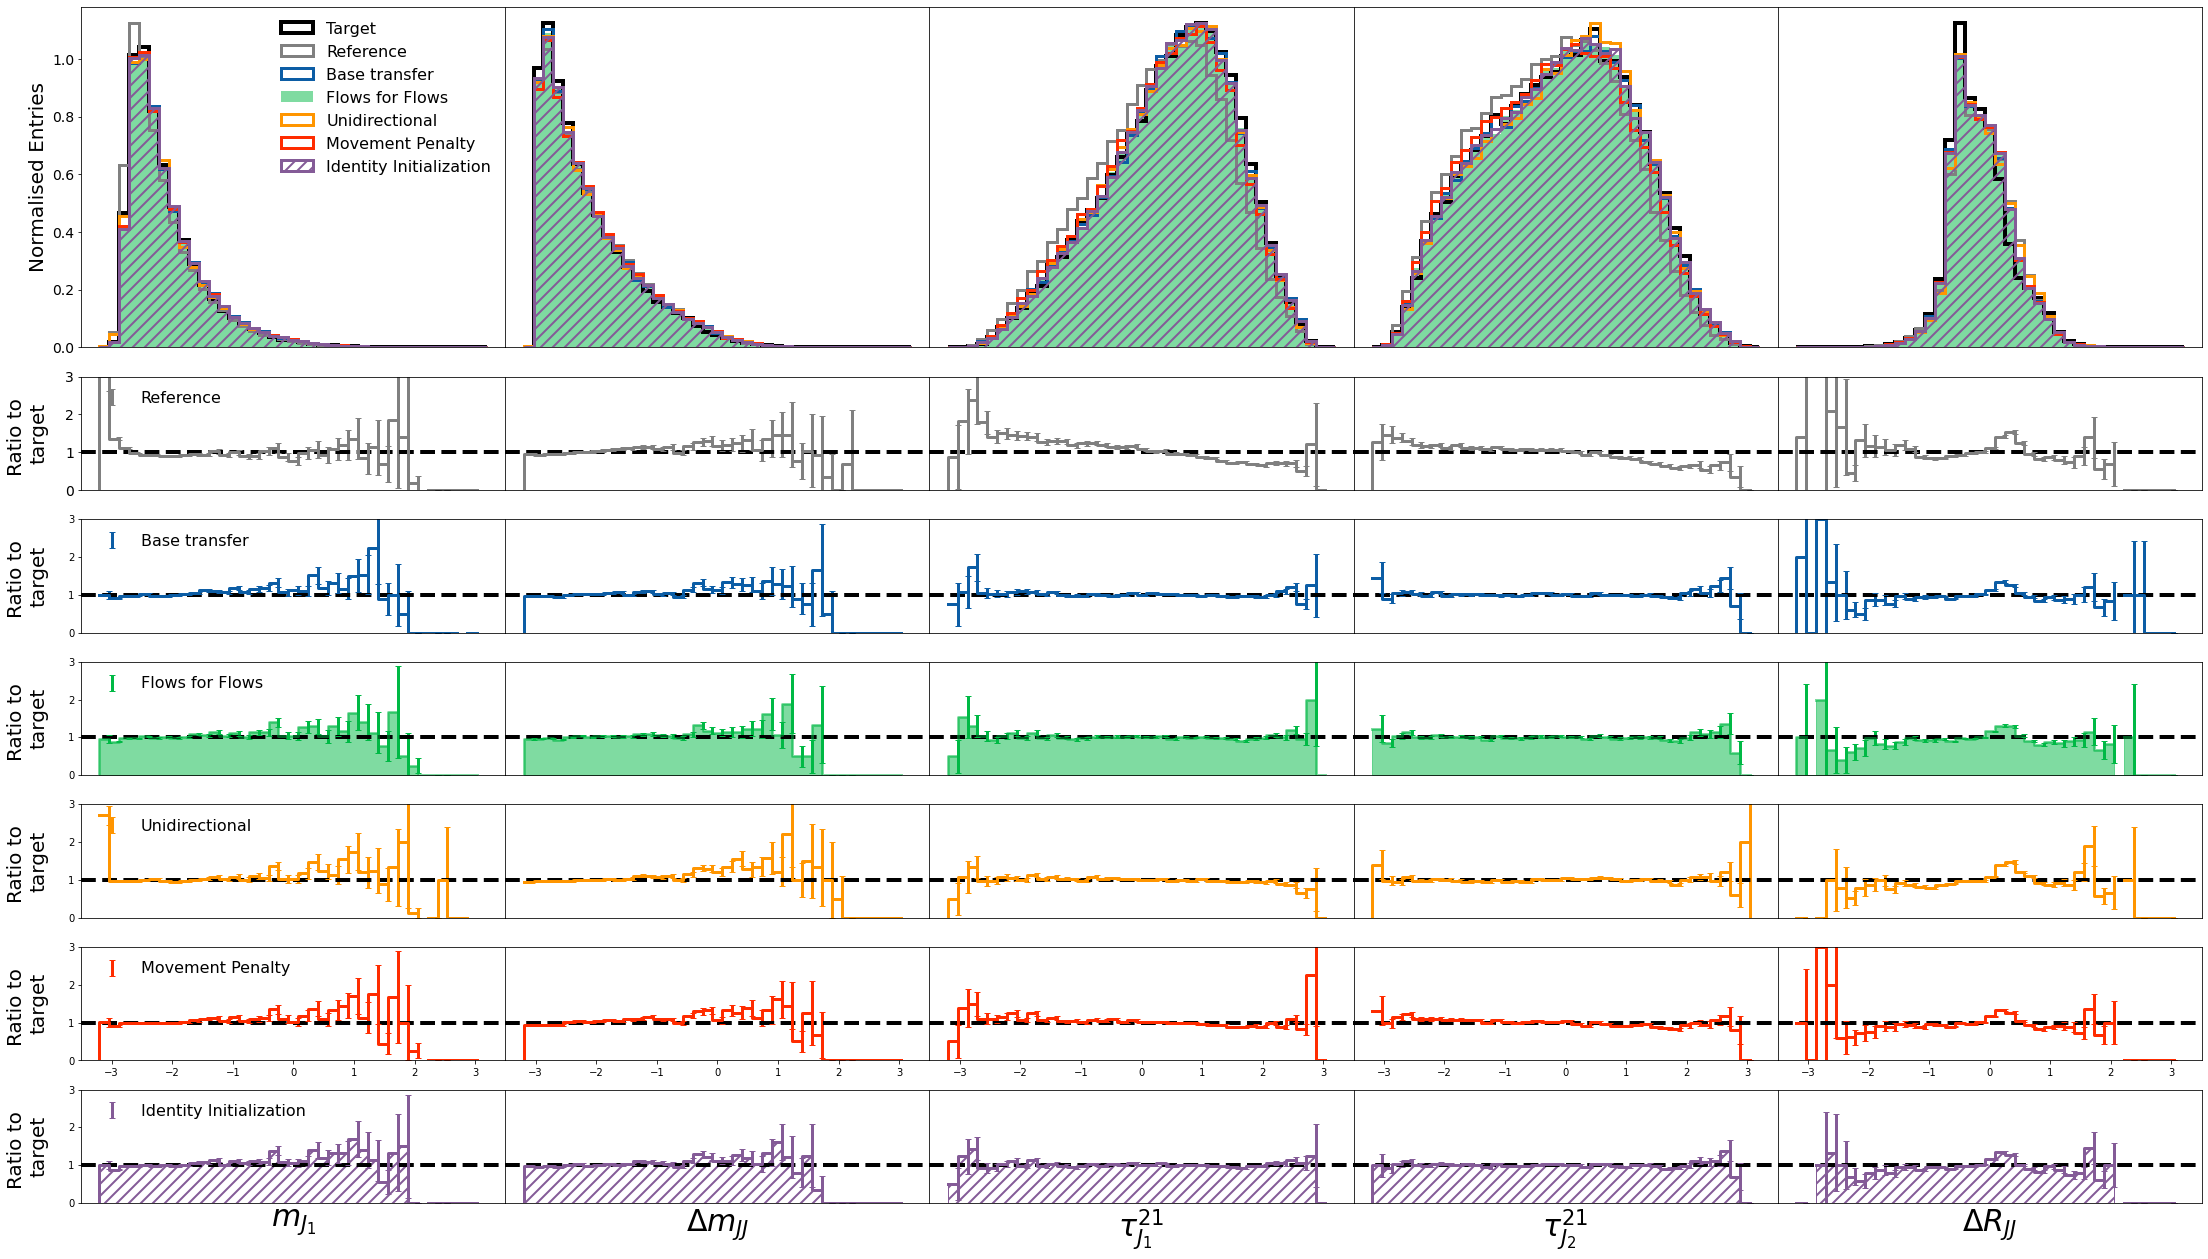

In [18]:

labels_dict = {"baseline": "Baseline",
               "reference": "Reference",
               "base_transfer":"Base transfer",
              "f4f":"Flows for Flows",
              "inverse":"Unidirectional",
              "L1":"Movement Penalty",
              "L1_identinit":"MP + II",
              "identinit":"Identity Initialization",
              }



style_dict = {"baseline":["step", "black", 1, "", 3],  # step, color, alpha, hash, linewidth,
              "reference":["step", "grey", 1, "", 3],  
             "base_transfer":["step", "#0C5DA5", 1, "", 3],
             "f4f":["stepfilled", "#00B945", .5, "", 3],
             "inverse":["step", "#FF9500", 1, "", 3],
             "L1":["step", "#FF2C00", 1, "", 3],
             "identinit":["step", "#845B97", 1, "//", 3]}

labels =  ["$m_{J_1}$", "$\Delta m_{JJ}$", "$\\tau^{21}_{J_1}$", "$\\tau^{21}_{J_2}$", "$\Delta R_{JJ}$"]

import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 2  # previous pdf hatch linewidth

f_1 = 20
f_2 = 16
f_3 = 14

# get summary stats

def get_errors_of_ratio(x, y, bins):
    
    """
    Using poisson errors, sigma = sqrt(n)
    (dz)**2 = (1/y)**2*(dx)**2 + (x/y**2)**2*(dy)**2)
    
    becomes (dz)**2 = (x/y**2) + (x**2/y**3)
    """
    
    x_values, _ = np.histogram(x, bins = bins, density = False)
    y_values, _ = np.histogram(y, bins = bins, density = False)
    
    dz_sq = (x_values/(y_values**2)) + ((x_values**2)/(y_values**3))
    
    return np.sqrt(dz_sq)
    
    

bins = np.linspace(-3.2, 3.2, 40)

fig, ax = plt.subplots(7, 5, figsize = (38, 22), gridspec_kw={'height_ratios': [3, 1, 1, 1, 1, 1, 1]})

for i in range(5):
    
    # get target histogram
    values_target, _ = np.histogram(val_dat_data[:,i].numpy(), bins = bins, density = True)
    
    ax[0, i].hist(val_dat_data[:,i].numpy(), bins = bins, label = "Target", histtype = "step", color = "black",
                          linewidth = 4, density = True) 
   
    for j, key in enumerate(transformed_data.keys()):
        # plot the distribution
        
        ax[0, i].hist(transformed_data[key][:,i], bins = bins, label = labels_dict[key], histtype = style_dict[key][0], color = style_dict[key][1],
                          alpha = style_dict[key][2],  hatch = style_dict[key][3],linewidth = style_dict[key][4], density = True) 
    
        # ratio plot
        ax[j+1,i].axhline(1, color = "black", linestyle = 'dashed', linewidth = 4)
        loc_values, _ = np.histogram(transformed_data[key][:,i], bins = bins, density = True)
        loc_ratio = np.nan_to_num(np.divide(loc_values, values_target))
        
        ax[j+1, i].step(bins[:-1], loc_ratio, color = style_dict[key][1],
                             alpha = style_dict[key][2], linewidth = 3) 
        
        errorbars = get_errors_of_ratio(transformed_data[key][:,i], val_dat_data[:,i].numpy(), bins)
        ax[j+1, i].errorbar(bins[:-1], loc_ratio, yerr = errorbars, color = style_dict[key][1],
                         elinewidth = 3, capsize = 3, label = labels_dict[key], linewidth = 0) 
            
        if key == "f4f":
            loc_ratio[loc_ratio < 0] = 0
            loc_ratio[loc_ratio > 10 ] = 0
            ax[j+1, i].fill_between(bins[:-1], loc_ratio, color = style_dict[key][1], alpha = style_dict[key][2], step = "pre")
        if key == "identinit":
            loc_ratio[loc_ratio < 0] = 0
            loc_ratio[loc_ratio > 10 ] = 0
            ax[j+1, i].fill_between(bins[:-1], loc_ratio, edgecolor = style_dict[key][1], alpha = style_dict[key][2], hatch="//",facecolor = "none", step = "pre")
            
        ax[j+1,0].set_ylabel("Ratio to \ntarget", fontsize = f_1)
        ax[j+1,0].legend(fontsize = f_2, loc = "upper left", frameon = False)
        ax[j+1,i].set_ylim(0, 3)
        
        if i != 0:
            ax[0,i].set_yticks([])
            ax[j+1,i].set_yticks([])
        else: 
            ax[j+1,i].set_yticks([0, 1, 2, 3])
            
        if j != 4:
            ax[j+1,i].set_xticks([])
  
    # bottom plot gets x_label
    ax[6,i].set_xlabel(labels[i], fontsize = f_1*1.5)
    
    ax[0,i].tick_params(axis='both', labelsize=f_3)
    ax[1,i].tick_params(axis='both', labelsize=f_3)
    
    ax[0,i].set_xticks([])
    ax[1,i].set_xticks([])
    

    
    

plt.setp(ax, xlim=(-3.5, 3.5))
fig.align_ylabels(ax[:, 0])
plt.subplots_adjust(wspace=0, hspace=.2)
        
ax[0,0].legend(fontsize = f_2, loc = "upper right", frameon = False)
ax[0,0].set_ylabel("Normalised Entries", fontsize = f_1)

plt.savefig(f"plots/science_feature_ratios.pdf", bbox_inches="tight")
plt.show()



# Distances traveled

In [21]:
total_distances_traveled = {}
feature_distances_traveled = {i:{} for i in range(5)}

# do the baseline
dels = sim_dataset.data[:n_transform].numpy() - dat_dataset.data[:n_transform].numpy()
for i in range(5):
    feature_distances_traveled[i]["baseline"] = np.abs(dels[:,i])
total_distances_traveled["baseline"] = np.sqrt(np.sum(dels**2, axis = 1))

# do the others
for key in transformed_data.keys():
    dels = sim_dataset.data[:n_transform].numpy() - transformed_data[key][:n_transform]
    for i in range(5):
        feature_distances_traveled[i][key] = np.abs(dels[:,i])
    total_distances_traveled[key] = np.sqrt(np.sum(dels**2, axis = 1))


Baseline & 2.576221227645874 & 0.9930650591850281 \\
Base transfer & 0.6916338205337524 & 0.34698209166526794 \\
Flows for Flows & 0.3129526674747467 & 0.08487502485513687 \\
Unidirectional & 0.33103519678115845 & 0.1260998398065567 \\
Movement Penalty & 0.22305986285209656 & 0.06405309587717056 \\
Identity Initialization & 0.30076855421066284 & 0.07677986472845078 \\


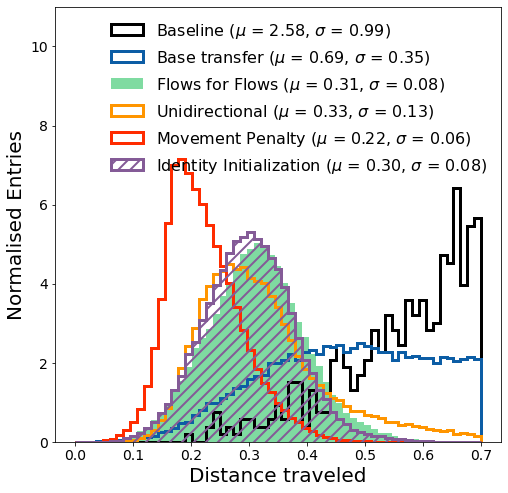

In [22]:
bins = np.linspace(0, .7, 60)
n_round = int(2)

fig = plt.figure(figsize = (8, 8))



for key in total_distances_traveled.keys():
    
    if key != "reference":
    
        label = labels_dict[key]
        loc_mean = np.mean(total_distances_traveled[key])
        loc_std = np.std(total_distances_traveled[key])

        str_mean = '{0:.{1}f}'.format(loc_mean, 2)
        std_std = '{0:.{1}f}'.format(loc_std, 2)


        stats = f" ($\mu$ = {str_mean}, $\sigma$ = {std_std})"

        plt.hist(total_distances_traveled[key], bins = bins, label = label+stats, density = True,
                histtype = style_dict[key][0], color = style_dict[key][1],
                              alpha = style_dict[key][2],  hatch = style_dict[key][3],linewidth = style_dict[key][4])


        print(f"{label} & {loc_mean} & {loc_std} \\\\")
    
    
plt.ylim(0, 11)  
plt.tick_params(axis='both', labelsize=f_3)
plt.xlabel("Distance traveled", fontsize = f_1)
plt.ylabel("Normalised Entries", fontsize = f_1)
plt.legend(fontsize = f_2, frameon = False, loc = "upper right")
plt.savefig(f"plots/science_distances_traveled_total.pdf", bbox_inches="tight")

plt.show()



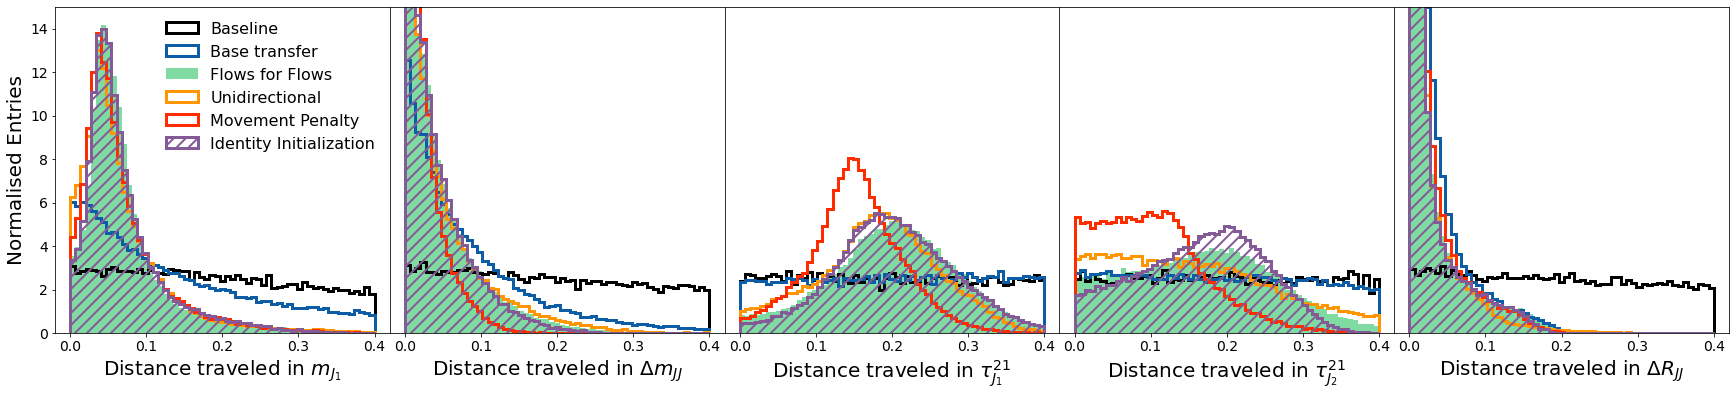

In [24]:
bins = np.linspace(0, .4, 60)

fig, ax = plt.subplots(1, 5, figsize = (30, 6))
for i in range(5):
    
    ax[i].set_ylim(0, 20)
    
    for key in total_distances_traveled.keys():
        if key != "reference":
    
            ax[i].hist(feature_distances_traveled[i][key], bins = bins, label = labels_dict[key], 
                       histtype = style_dict[key][0], density = True,color = style_dict[key][1],
                              alpha = style_dict[key][2],  hatch = style_dict[key][3], linewidth = style_dict[key][4])
    ax[i].set_xlabel(f"Distance traveled in {labels[i]}", fontsize = f_1)
    ax[i].set_ylim(0,15)
    ax[i].tick_params(axis='both', labelsize=f_3)
    if i != 0:
        ax[i].set_yticks([])


plt.subplots_adjust(wspace=0, hspace=0)
ax[0].legend(fontsize = f_2, loc = "upper right", frameon = False)
ax[0].set_ylabel("Normalised Entries", fontsize = f_1)
plt.savefig(f"plots/science_distances_traveled_features.pdf", bbox_inches="tight")
plt.show()

